# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [3]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [4]:
data = np.load("mars_for_students_cleaned.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 250

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [6]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [7]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [9]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [10]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [11]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label


In [12]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
      ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...


<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-b58cb7234dec>:52: UserWarning: Argument 'mask_fill_value' is no

WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


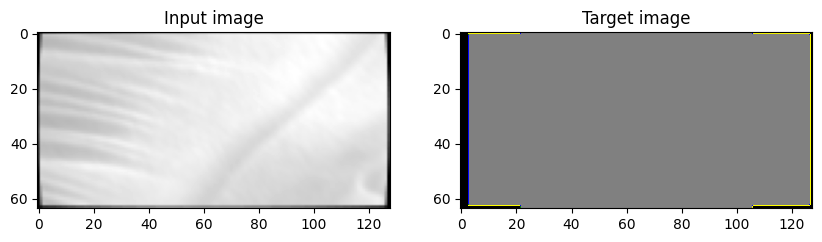

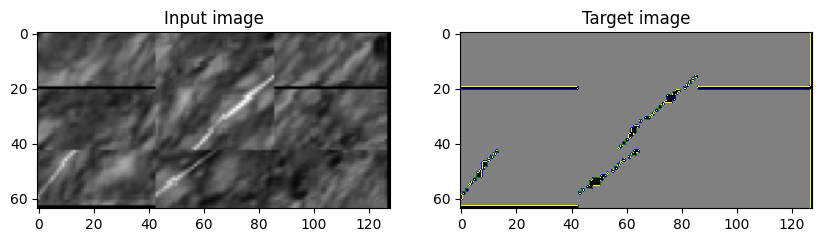

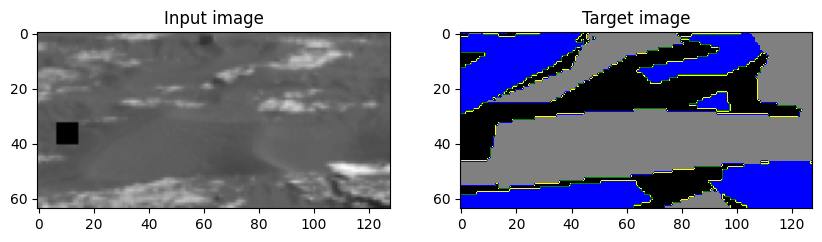

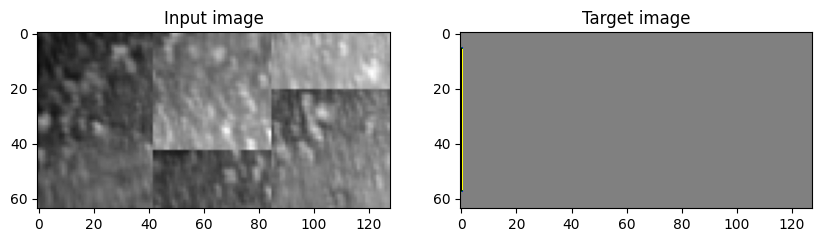

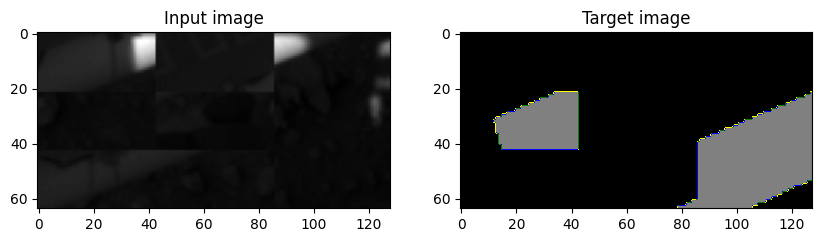

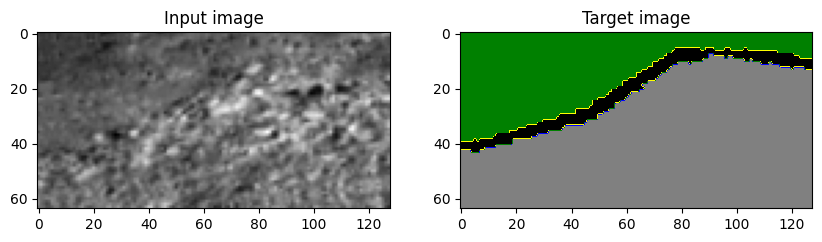

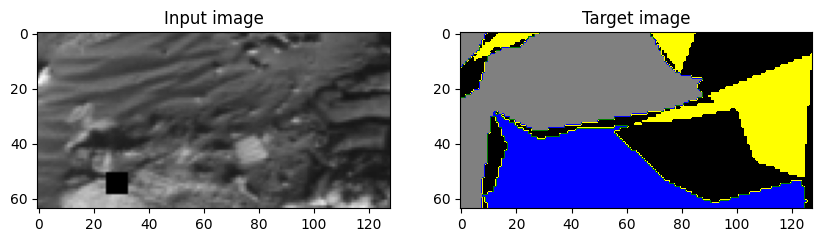

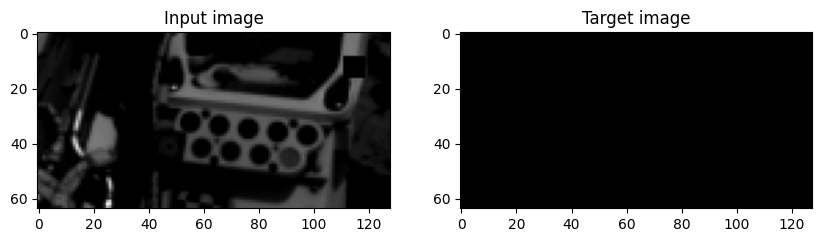

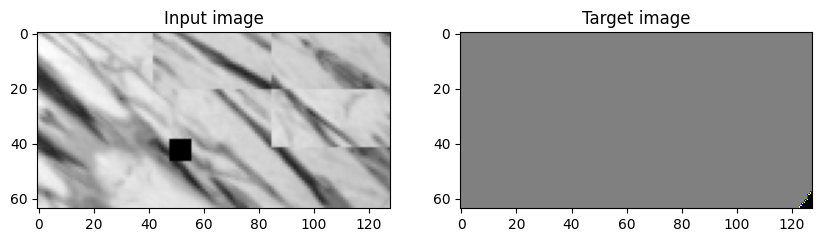

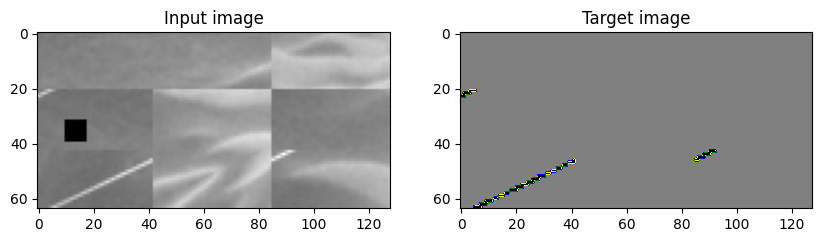

In [13]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [14]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [15]:
def aspp_block(x, filter_size, number_filters):
    """
    Atrous spatial pyramid pooling (ASPP)
    """
    y1 = tfkl.Conv2D(number_filters, (1, 1), kernel_initializer='lecun_uniform', padding='same', activation='relu', use_bias=False)(x)
    y2 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=6, padding='same', activation='relu', use_bias=False)(x)
    y3 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=12, padding='same', activation='relu', use_bias=False)(x)
    y4 = tfkl.Conv2D(number_filters, (3, 3), kernel_initializer='lecun_uniform', dilation_rate=18, padding='same', activation='relu', use_bias=False)(x)

    # Global Average Pooling
    # global_avg_pool = tfkl.GlobalAveragePooling2D()(x)
    # global_avg_pool = tfkl.Reshape((1, 1, tf.shape(global_avg_pool)[-1]))(global_avg_pool)
    # global_avg_pool = tfkl.Conv2D(number_filters, kernel_size=1, activation='relu', padding='same')(global_avg_pool)
    # global_avg_pool = tfkl.UpSampling2D(size=(tf.shape(x)[1], tf.shape(x)[2]), interpolation='bilinear')(global_avg_pool)

    concat = tfkl.Concatenate()([y1, y2, y3, y4])
    concat = tfkl.Conv2D(number_filters, (1, 1), padding='same', activation='relu')(concat)
    return concat

In [16]:
def Attention_ResUNet_with_aspp(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # downsample the input to match every downsampling made
    x_64 = tfkl.AveragePooling2D(pool_size=(2,2))(inputs)
    x_32 = tfkl.AveragePooling2D(pool_size=(4,4))(inputs)
    x_16 = tfkl.AveragePooling2D(pool_size=(8,8))(inputs)
    x_8 = tfkl.AveragePooling2D(pool_size=(16,16))(inputs)

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    conc_64 = tfkl.concatenate([pool_64, x_64], axis=axis)
    # DownRes 2
    conv_64 = res_conv_block(conc_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    conc_32 = tfkl.concatenate([pool_32, x_32], axis=axis)
    # DownRes 3
    conv_32 = res_conv_block(conc_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    conc_16 = tfkl.concatenate([pool_16, x_16], axis=axis)
    # DownRes 4
    conv_16 = res_conv_block(conc_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    conc_8 = tfkl.concatenate([pool_8, x_8], axis=axis)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(conc_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    aspp = aspp_block(conv_8, FILTER_SIZE, 16*FILTER_NUM)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(aspp)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    up_out = tfkl.UpSampling2D(size=(UP_SAMP_SIZE**(3), UP_SAMP_SIZE**(3)), data_format="channels_last")(up_conv_16)
    supervision_1 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_1')(up_out)

    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    up_out_2 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE**(2), UP_SAMP_SIZE**(2)), data_format="channels_last")(up_conv_32)
    supervision_2 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_2')(up_out_2)

    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    up_out_3 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    supervision_3 = tfkl.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax', name='supervision_3')(up_out_3)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('softmax')(conv_final)

    # Model integration
    model = tfk.models.Model(inputs, outputs = [conv_final, supervision_3, supervision_2, supervision_1], name="AttentionResUNet_with_aspp_and_deep_supervision")
    return model


In [17]:
model = Attention_ResUNet_with_aspp()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


Model: "AttentionResUNet_with_aspp_and_deep_supervision"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 32)  │          128 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 32)  │           64 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 32)  │        9,248 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 32)  │          128 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 32)  │          128 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 32)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ average_pooling2d      │ (None, 32, 64, 1)    │            0 │ input_layer[0][0]   │    -    │
│ (AveragePooling2D)     │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate            │ (None, 32, 64, 33)   │            0 │ max_pooling2d[0][0… │    -    │
│ (Concatenate)          │                      │              │ average_pooling2d[… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 64)   │       19,072 │ concatenate[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3

 Total params: 18,187,980 (69.38 MB)

 Trainable params: 18,177,218 (69.34 MB)

 Non-trainable params: 10,762 (42.04 KB)

In [18]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [19]:
from keras import backend as K


def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    learning_rate = 0.5 * target_lr * (
    1 + tf.cos(
        tf.constant(np.pi, dtype=tf.float32) *
        (tf.cast(global_step, tf.float32) - tf.cast(warmup_steps, tf.float32) - tf.cast(hold, tf.float32)) /
        float(total_steps - warmup_steps - hold)
    )
    )


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(tfk.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )

    def get_config(self):
        return {
            "start_lr": self.start_lr,
            "target_lr": self.target_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "hold": self.hold
        }


In [20]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            plt.close()

In [24]:



def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Clip predictions to prevent log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    mask = tf.cast(tf.reduce_sum(y_true, axis=-1) > 0, tf.float32) #ignore class 0

    # Cross entropy loss
    cross_entropy_loss = -y_true * tf.math.log(y_pred)

    # Focal loss component
    focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy_loss

    focal_loss = focal_loss * tf.expand_dims(mask, axis=-1)
    return tf.reduce_sum(focal_loss, axis=-1)

# Dice Loss function
def dice_loss(y_true, y_pred, epsilon=1e-6):
    mask = tf.cast(tf.reduce_sum(y_true, axis=-1) > 0, tf.float32)

    # Compute Dice coefficient
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    dice = 1 - (2.0 * intersection + epsilon) / (union + epsilon)

    # Apply mask to ignore class 0
    dice = dice * mask

    return tf.reduce_mean(dice)

# Combined Loss function
def combined_loss(y_true, y_pred, alpha=0.25, gamma=2.0, epsilon=1e-6):
    focal = focal_loss(y_true, y_pred, alpha, gamma)
    dice = dice_loss(y_true, y_pred, epsilon)
    return tf.reduce_mean(focal + dice)


@tf.function
def deep_supervision_loss(y_true, outputs, weights = [0.4, 0.3, 0.2, 0.1]):
    """
    Combine the final output loss and intermediate losses with weights.
    Args:
        y_true: Ground truth labels.
        outputs: List of outputs from model [final_output, supervision_1, supervision_2].
        weights: List of weights for each output.
    Returns:
        Combined loss.
    """

    losses = []

    for i in range(len(weights)):
        pred = outputs[i]
        # y_resized = tf.image.resize(y_true, [*pred.shape[0:2]])

        losses.append(weights[i] * combined_loss(y_true, pred))



    return tf.reduce_sum(losses)

# If batched
total_steps = len(train_dataset)*EPOCHS
# 5% of the steps
warmup_steps = int(0.10*total_steps)

#lr_schedule = WarmUpCosineDecay(start_lr=0.0, target_lr=0.05, warmup_steps=warmup_steps, total_steps=total_steps, hold=warmup_steps)
initial_learning_rate = 0.1
steps_per_epoch = len(train_dataset) * BATCH_SIZE
learning_rate_decay_factor = 0.99
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

print("Compiling model...")
model.compile(
    #loss=lambda y_true, y_pred: deep_supervision_loss(y_true, y_pred),
    #loss=combined_loss,
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0),
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0),
        ],

    jit_compile=True,
    loss_weights=[1, 0.3, 0.2, 0.15],
    optimizer=tf.keras.optimizers.AdamW(lr_schedule, beta_1=0.99),
    metrics=[ MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]), "accuracy", "accuracy", "accuracy"]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [25]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_activation_30_mean_iou',
    mode='max',
    patience=30,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_activation_30_mean_iou",
    factor=0.5,
    patience=30
)

Epoch 1/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - activation_30_mean_iou: 0.4896 - loss: 0.5441   

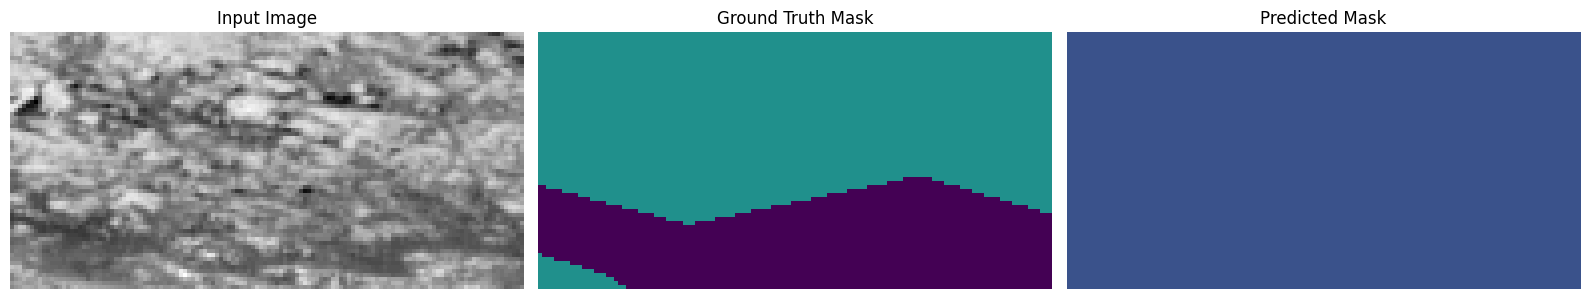

30/30 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - activation_30_mean_iou: 0.4893 - loss: 0.5442 - val_activation_30_mean_iou: 0.4401 - val_loss: 0.6267
Epoch 2/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 68s 648ms/step - activation_30_mean_iou: 0.4887 - loss: 0.5484 - val_activation_30_mean_iou: 0.1387 - val_loss: 3.2664
Epoch 3/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 645ms/step - activation_30_mean_iou: 0.4980 - loss: 0.5212 - val_activation_30_mean_iou: 0.4600 - val_loss: 0.5986
Epoch 4/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 642ms/step - activation_30_mean_iou: 0.5039 - loss: 0.5160 - val_activation_30_mean_iou: 0.2456 - val_loss: 2.0465
Epoch 5/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 638ms/step - activation_30_mean_iou: 0.4940 - loss: 0.5145 - val_activation_30_mean_iou: 0.3585 - val_loss: 1.3985
Epoch 6/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - activation_30_mean_iou: 0.4831 - loss: 0.5398

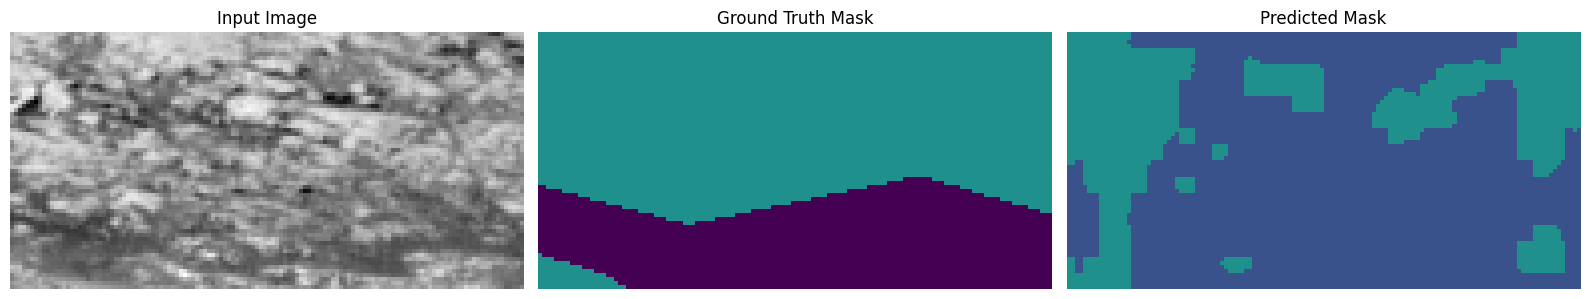

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 658ms/step - activation_30_mean_iou: 0.4836 - loss: 0.5384 - val_activation_30_mean_iou: 0.4496 - val_loss: 0.5647
Epoch 7/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - activation_30_mean_iou: 0.4986 - loss: 0.5017 - val_activation_30_mean_iou: 0.3625 - val_loss: 1.1329
Epoch 8/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 640ms/step - activation_30_mean_iou: 0.4994 - loss: 0.5008 - val_activation_30_mean_iou: 0.3493 - val_loss: 0.9417
Epoch 9/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 639ms/step - activation_30_mean_iou: 0.5114 - loss: 0.4919 - val_activation_30_mean_iou: 0.1718 - val_loss: 2.7151
Epoch 10/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - activation_30_mean_iou: 0.5092 - loss: 0.4946 - val_activation_30_mean_iou: 0.1380 - val_loss: 2.0914
Epoch 11/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - activation_30_mean_iou: 0.5172 - loss: 0.4635

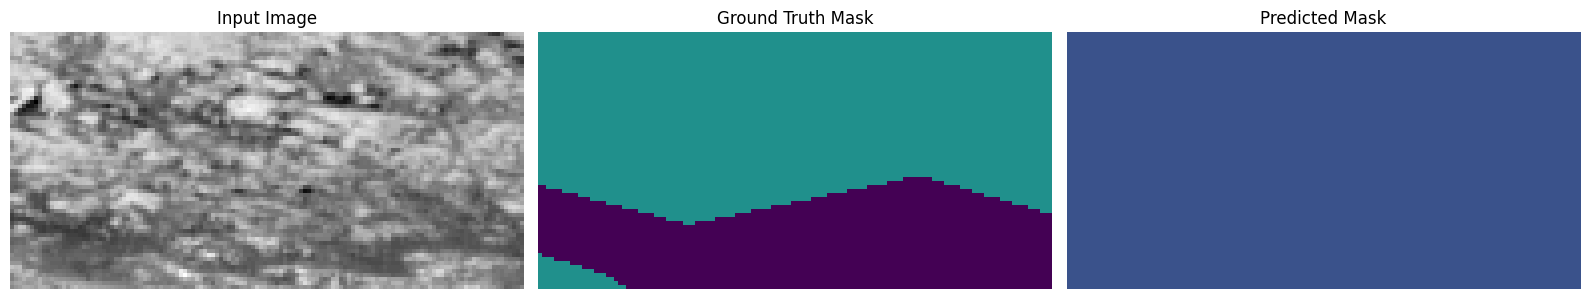

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - activation_30_mean_iou: 0.5173 - loss: 0.4631 - val_activation_30_mean_iou: 0.2505 - val_loss: 1.7207
Epoch 12/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - activation_30_mean_iou: 0.5216 - loss: 0.4658 - val_activation_30_mean_iou: 0.1545 - val_loss: 1.6572
Epoch 13/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - activation_30_mean_iou: 0.5050 - loss: 0.5132 - val_activation_30_mean_iou: 0.3031 - val_loss: 0.8876
Epoch 14/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 638ms/step - activation_30_mean_iou: 0.5144 - loss: 0.4837 - val_activation_30_mean_iou: 0.3831 - val_loss: 0.7617
Epoch 15/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - activation_30_mean_iou: 0.5126 - loss: 0.4724 - val_activation_30_mean_iou: 0.2450 - val_loss: 1.9671
Epoch 16/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - activation_30_mean_iou: 0.5171 - loss: 0.4664

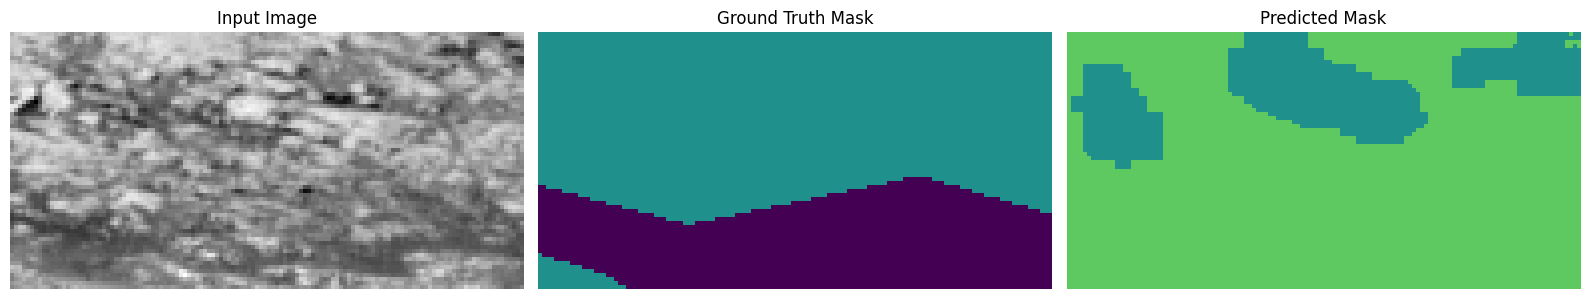

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 647ms/step - activation_30_mean_iou: 0.5174 - loss: 0.4657 - val_activation_30_mean_iou: 0.1673 - val_loss: 2.1544
Epoch 17/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - activation_30_mean_iou: 0.5247 - loss: 0.4467 - val_activation_30_mean_iou: 0.1062 - val_loss: 2.3400
Epoch 18/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 638ms/step - activation_30_mean_iou: 0.5240 - loss: 0.4367 - val_activation_30_mean_iou: 0.1221 - val_loss: 3.4006
Epoch 19/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 635ms/step - activation_30_mean_iou: 0.5248 - loss: 0.4427 - val_activation_30_mean_iou: 0.0681 - val_loss: 4.0026
Epoch 20/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - activation_30_mean_iou: 0.5220 - loss: 0.4447 - val_activation_30_mean_iou: 0.0764 - val_loss: 3.2986
Epoch 21/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - activation_30_mean_iou: 0.5399 - loss: 0.4120

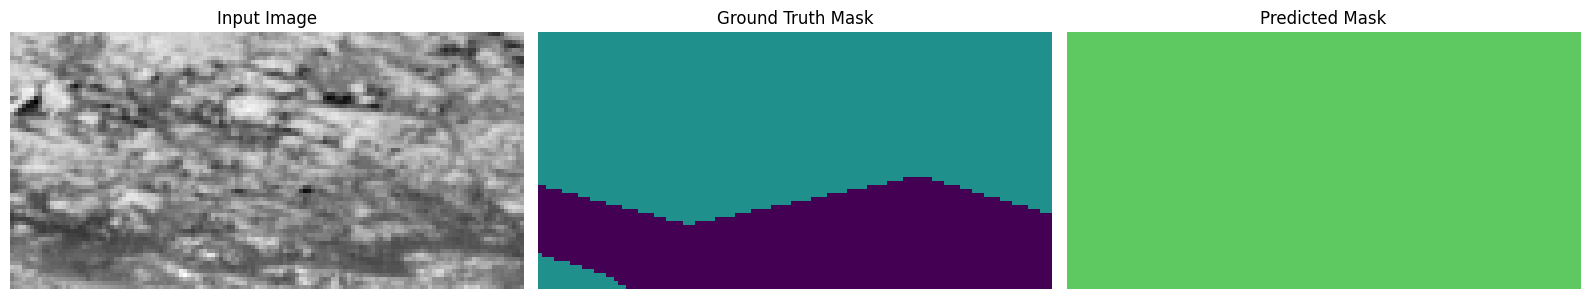

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 662ms/step - activation_30_mean_iou: 0.5400 - loss: 0.4118 - val_activation_30_mean_iou: 0.0666 - val_loss: 3.6777
Epoch 22/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - activation_30_mean_iou: 0.5228 - loss: 0.4344 - val_activation_30_mean_iou: 0.2245 - val_loss: 1.2732
Epoch 23/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - activation_30_mean_iou: 0.5399 - loss: 0.4171 - val_activation_30_mean_iou: 0.2180 - val_loss: 1.9008
Epoch 24/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 647ms/step - activation_30_mean_iou: 0.5268 - loss: 0.4222 - val_activation_30_mean_iou: 0.1532 - val_loss: 2.3347
Epoch 25/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 639ms/step - activation_30_mean_iou: 0.5347 - loss: 0.4198 - val_activation_30_mean_iou: 0.1960 - val_loss: 1.3585
Epoch 26/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - activation_30_mean_iou: 0.5344 - loss: 0.4227

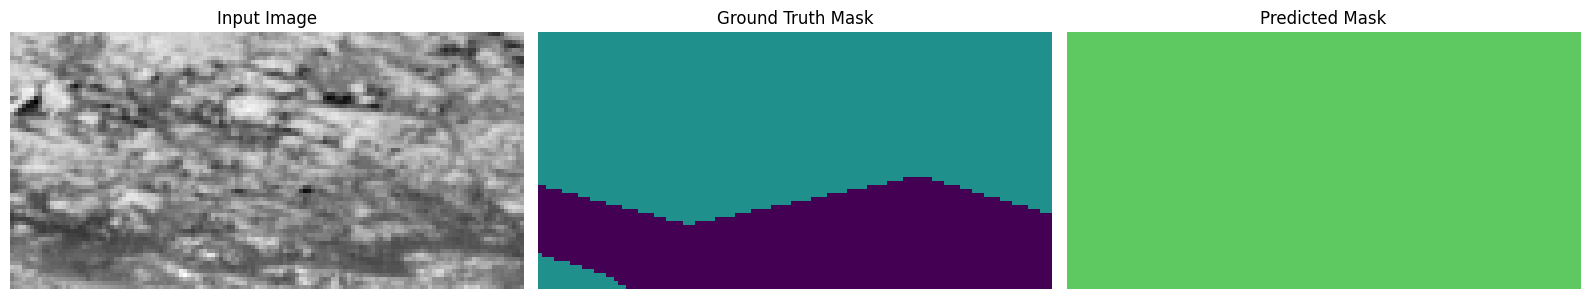

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 658ms/step - activation_30_mean_iou: 0.5344 - loss: 0.4227 - val_activation_30_mean_iou: 0.0807 - val_loss: 2.2228
Epoch 27/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - activation_30_mean_iou: 0.5312 - loss: 0.4204 - val_activation_30_mean_iou: 0.2658 - val_loss: 1.1537
Epoch 28/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 642ms/step - activation_30_mean_iou: 0.5366 - loss: 0.4245 - val_activation_30_mean_iou: 0.3306 - val_loss: 1.0504
Epoch 29/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 640ms/step - activation_30_mean_iou: 0.5434 - loss: 0.4002 - val_activation_30_mean_iou: 0.2929 - val_loss: 1.3360
Epoch 30/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 647ms/step - activation_30_mean_iou: 0.5233 - loss: 0.4619 - val_activation_30_mean_iou: 0.5352 - val_loss: 0.4863
Epoch 31/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - activation_30_mean_iou: 0.5411 - loss: 0.4060

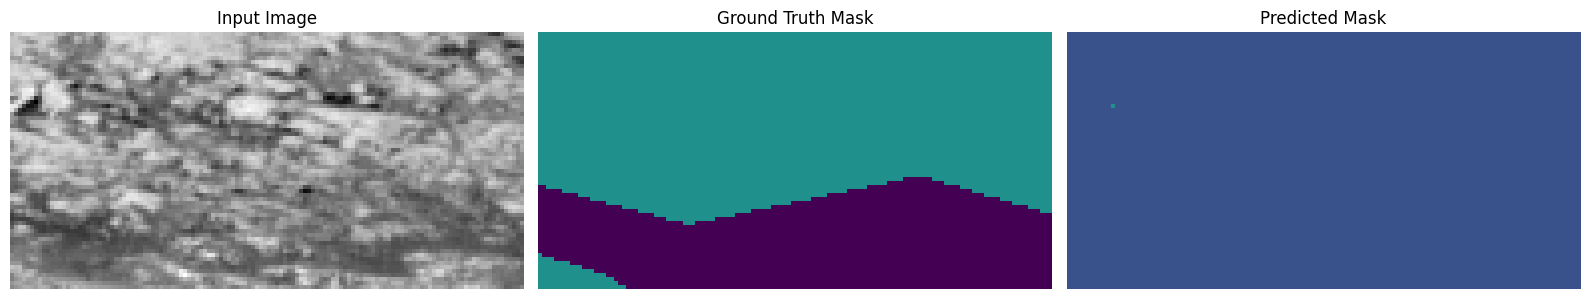

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 651ms/step - activation_30_mean_iou: 0.5414 - loss: 0.4056 - val_activation_30_mean_iou: 0.2990 - val_loss: 1.0914
Epoch 32/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 641ms/step - activation_30_mean_iou: 0.5510 - loss: 0.3919 - val_activation_30_mean_iou: 0.3201 - val_loss: 1.4264
Epoch 33/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - activation_30_mean_iou: 0.5502 - loss: 0.4062 - val_activation_30_mean_iou: 0.4354 - val_loss: 0.6055
Epoch 34/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - activation_30_mean_iou: 0.5597 - loss: 0.3601 - val_activation_30_mean_iou: 0.3743 - val_loss: 0.9555
Epoch 35/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - activation_30_mean_iou: 0.5404 - loss: 0.4110 - val_activation_30_mean_iou: 0.3113 - val_loss: 1.1678
Epoch 36/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - activation_30_mean_iou: 0.5402 - loss: 0.4202

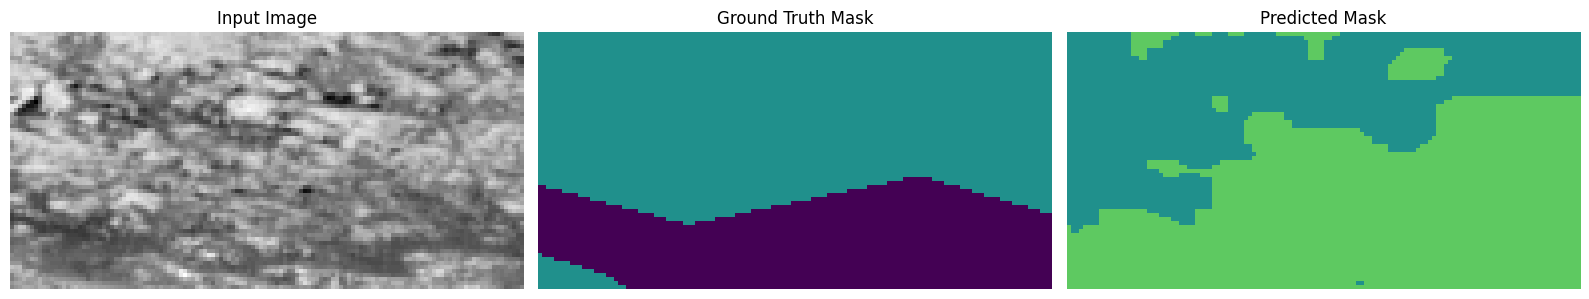

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - activation_30_mean_iou: 0.5406 - loss: 0.4192 - val_activation_30_mean_iou: 0.2311 - val_loss: 1.4586
Epoch 37/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - activation_30_mean_iou: 0.5424 - loss: 0.4152 - val_activation_30_mean_iou: 0.2400 - val_loss: 3.2167
Epoch 38/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 639ms/step - activation_30_mean_iou: 0.5385 - loss: 0.4328 - val_activation_30_mean_iou: 0.2479 - val_loss: 2.3159
Epoch 39/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 643ms/step - activation_30_mean_iou: 0.5537 - loss: 0.3824 - val_activation_30_mean_iou: 0.2506 - val_loss: 1.5848
Epoch 40/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - activation_30_mean_iou: 0.5554 - loss: 0.3807 - val_activation_30_mean_iou: 0.3910 - val_loss: 0.7401
Epoch 41/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - activation_30_mean_iou: 0.5546 - loss: 0.4048

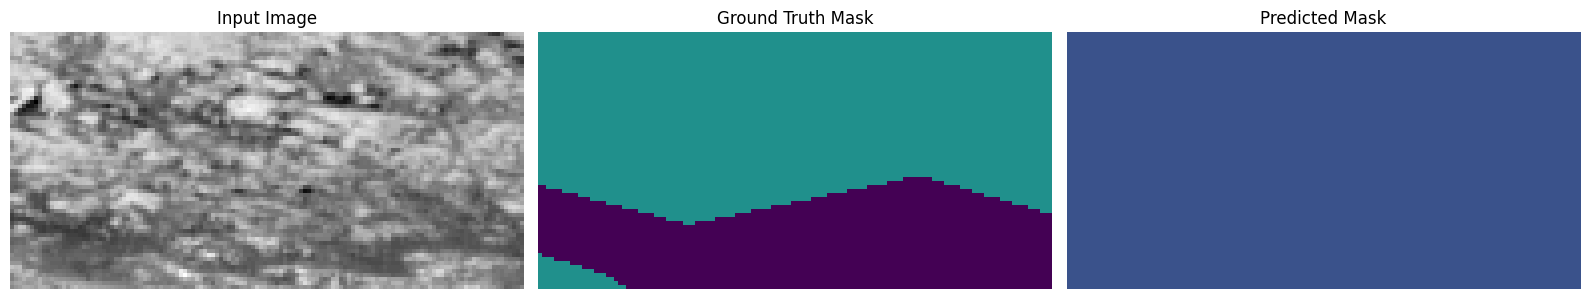

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 655ms/step - activation_30_mean_iou: 0.5548 - loss: 0.4038 - val_activation_30_mean_iou: 0.2850 - val_loss: 1.6116
Epoch 42/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - activation_30_mean_iou: 0.5578 - loss: 0.3790 - val_activation_30_mean_iou: 0.3097 - val_loss: 0.9549
Epoch 43/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 643ms/step - activation_30_mean_iou: 0.5710 - loss: 0.3607 - val_activation_30_mean_iou: 0.2431 - val_loss: 1.3633
Epoch 44/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 637ms/step - activation_30_mean_iou: 0.5484 - loss: 0.3845 - val_activation_30_mean_iou: 0.3748 - val_loss: 0.9431
Epoch 45/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 642ms/step - activation_30_mean_iou: 0.5672 - loss: 0.3814 - val_activation_30_mean_iou: 0.1979 - val_loss: 1.8913
Epoch 46/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - activation_30_mean_iou: 0.5397 - loss: 0.3992

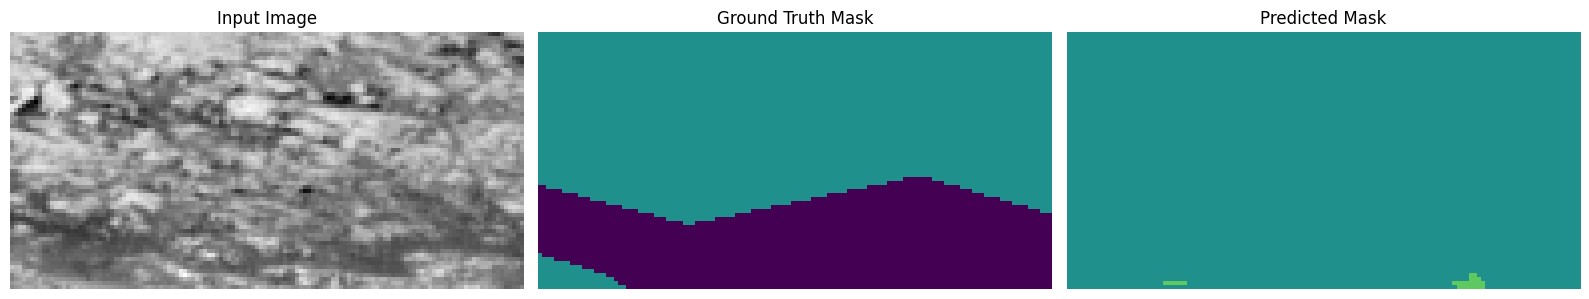

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 654ms/step - activation_30_mean_iou: 0.5401 - loss: 0.3985 - val_activation_30_mean_iou: 0.5434 - val_loss: 0.4804
Epoch 47/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 641ms/step - activation_30_mean_iou: 0.5468 - loss: 0.3948 - val_activation_30_mean_iou: 0.2710 - val_loss: 1.2786
Epoch 48/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - activation_30_mean_iou: 0.5484 - loss: 0.3974 - val_activation_30_mean_iou: 0.3244 - val_loss: 1.0616
Epoch 49/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - activation_30_mean_iou: 0.5607 - loss: 0.3743 - val_activation_30_mean_iou: 0.5293 - val_loss: 0.4370
Epoch 50/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 641ms/step - activation_30_mean_iou: 0.5599 - loss: 0.3683 - val_activation_30_mean_iou: 0.4976 - val_loss: 0.5630
Epoch 51/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - activation_30_mean_iou: 0.5786 - loss: 0.3568

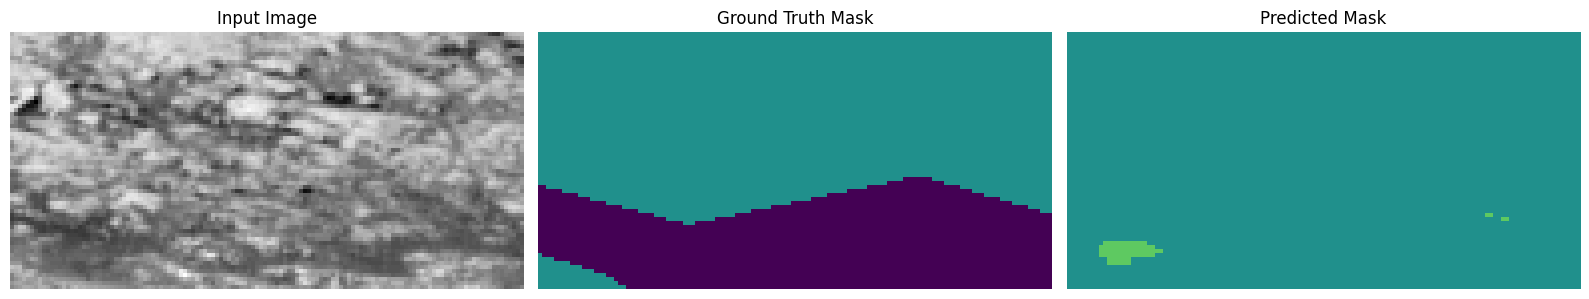

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - activation_30_mean_iou: 0.5783 - loss: 0.3569 - val_activation_30_mean_iou: 0.5141 - val_loss: 0.4859
Epoch 52/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - activation_30_mean_iou: 0.5674 - loss: 0.3804 - val_activation_30_mean_iou: 0.4307 - val_loss: 0.6706
Epoch 53/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - activation_30_mean_iou: 0.5500 - loss: 0.3933 - val_activation_30_mean_iou: 0.3921 - val_loss: 0.7972
Epoch 54/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 642ms/step - activation_30_mean_iou: 0.5640 - loss: 0.3657 - val_activation_30_mean_iou: 0.5051 - val_loss: 0.4988
Epoch 55/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - activation_30_mean_iou: 0.5671 - loss: 0.3659 - val_activation_30_mean_iou: 0.2250 - val_loss: 1.4107
Epoch 56/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - activation_30_mean_iou: 0.5671 - loss: 0.3568

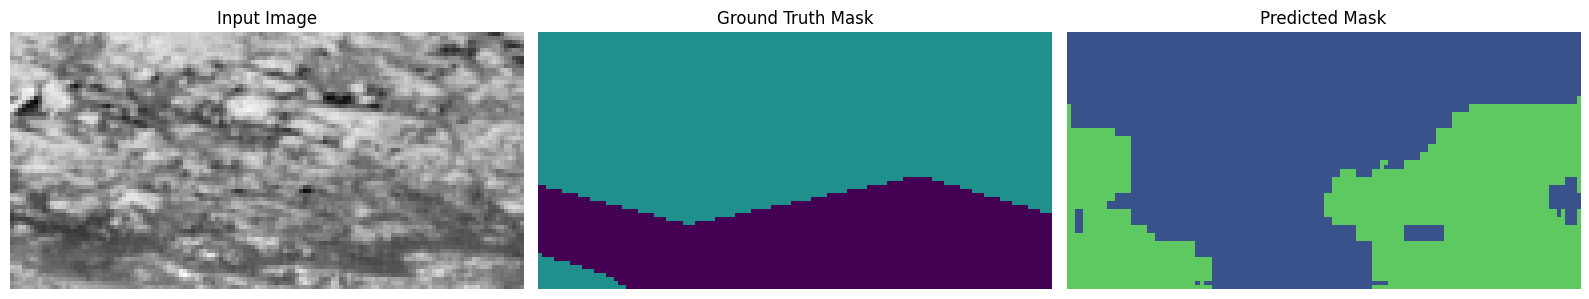

30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 650ms/step - activation_30_mean_iou: 0.5671 - loss: 0.3568 - val_activation_30_mean_iou: 0.1977 - val_loss: 1.6420
Epoch 57/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - activation_30_mean_iou: 0.5512 - loss: 0.3829 - val_activation_30_mean_iou: 0.2411 - val_loss: 1.9700
Epoch 58/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 641ms/step - activation_30_mean_iou: 0.5676 - loss: 0.3797 - val_activation_30_mean_iou: 0.3631 - val_loss: 0.9188
Epoch 59/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - activation_30_mean_iou: 0.5649 - loss: 0.3730 - val_activation_30_mean_iou: 0.4012 - val_loss: 0.6804
Epoch 60/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 642ms/step - activation_30_mean_iou: 0.5840 - loss: 0.3247 - val_activation_30_mean_iou: 0.3617 - val_loss: 0.9337
Epoch 61/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - activation_30_mean_iou: 0.5824 - loss: 0.3301

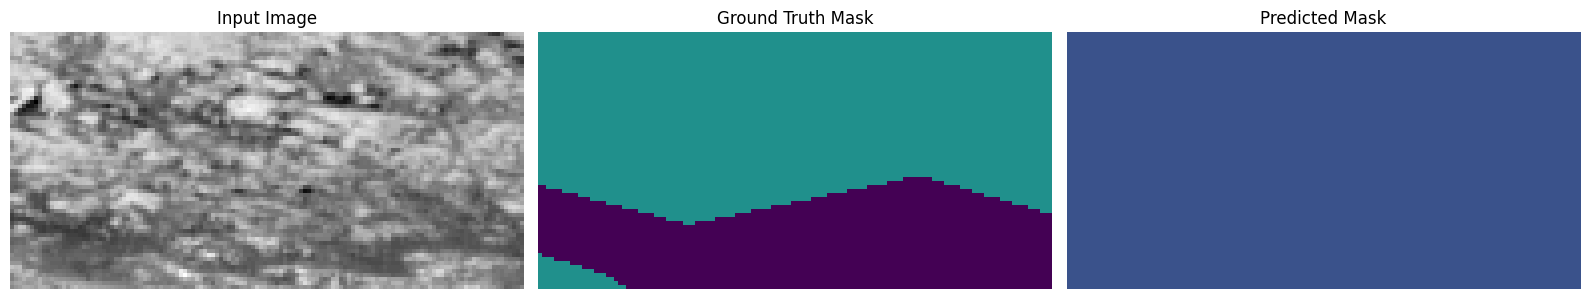

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 650ms/step - activation_30_mean_iou: 0.5826 - loss: 0.3297 - val_activation_30_mean_iou: 0.3313 - val_loss: 1.0065
Epoch 62/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - activation_30_mean_iou: 0.5784 - loss: 0.3534 - val_activation_30_mean_iou: 0.3878 - val_loss: 0.9524
Epoch 63/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - activation_30_mean_iou: 0.5740 - loss: 0.3511 - val_activation_30_mean_iou: 0.3728 - val_loss: 0.9143
Epoch 64/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 642ms/step - activation_30_mean_iou: 0.5967 - loss: 0.3127 - val_activation_30_mean_iou: 0.4231 - val_loss: 0.6770
Epoch 65/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 643ms/step - activation_30_mean_iou: 0.5825 - loss: 0.3400 - val_activation_30_mean_iou: 0.2123 - val_loss: 1.4333
Epoch 66/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - activation_30_mean_iou: 0.5770 - loss: 0.3435

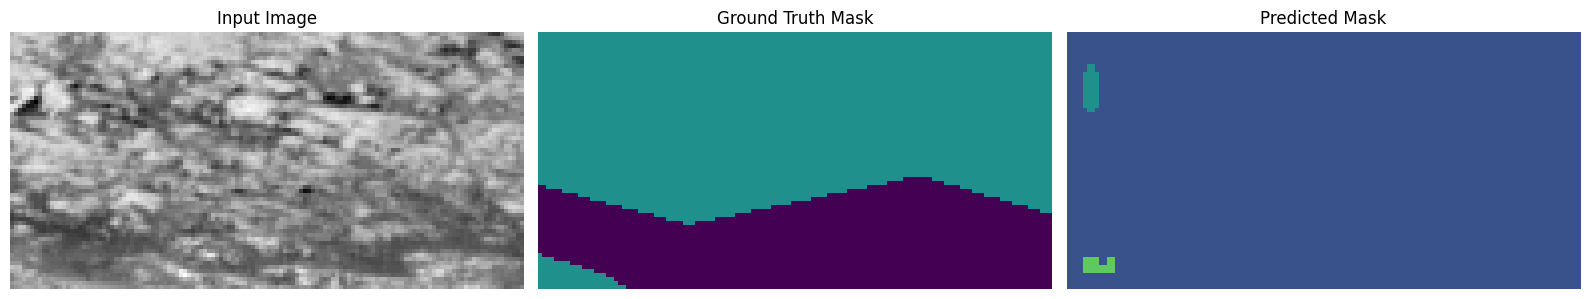

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 656ms/step - activation_30_mean_iou: 0.5773 - loss: 0.3430 - val_activation_30_mean_iou: 0.3965 - val_loss: 0.7372
Epoch 67/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - activation_30_mean_iou: 0.5683 - loss: 0.3559 - val_activation_30_mean_iou: 0.3717 - val_loss: 0.7725
Epoch 68/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - activation_30_mean_iou: 0.5652 - loss: 0.3650 - val_activation_30_mean_iou: 0.4193 - val_loss: 0.6553
Epoch 69/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 640ms/step - activation_30_mean_iou: 0.5690 - loss: 0.3444 - val_activation_30_mean_iou: 0.1175 - val_loss: 2.0754
Epoch 70/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - activation_30_mean_iou: 0.5748 - loss: 0.3439 - val_activation_30_mean_iou: 0.2058 - val_loss: 1.6244
Epoch 71/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - activation_30_mean_iou: 0.5887 - loss: 0.3331

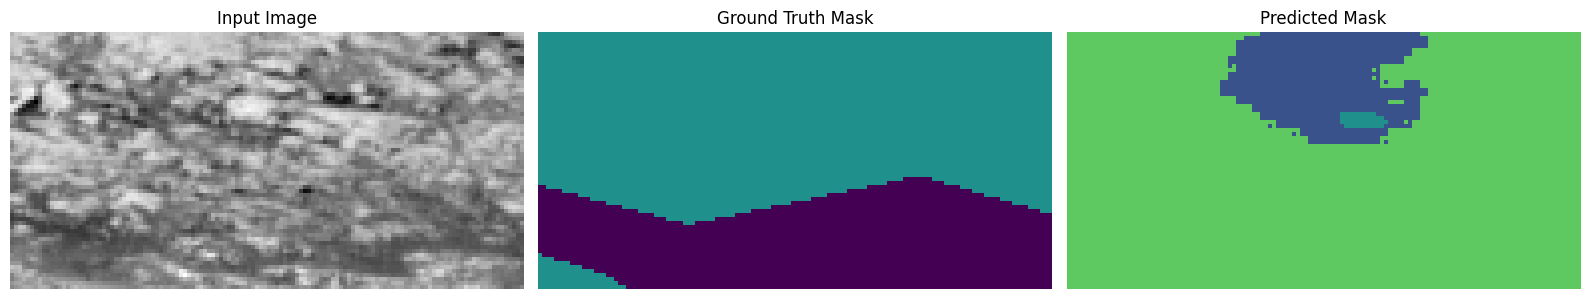

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - activation_30_mean_iou: 0.5886 - loss: 0.3329 - val_activation_30_mean_iou: 0.2434 - val_loss: 1.4517
Epoch 72/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 636ms/step - activation_30_mean_iou: 0.5777 - loss: 0.3354 - val_activation_30_mean_iou: 0.1852 - val_loss: 1.8371
Epoch 73/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 639ms/step - activation_30_mean_iou: 0.5716 - loss: 0.3319 - val_activation_30_mean_iou: 0.2018 - val_loss: 2.0821
Epoch 74/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 632ms/step - activation_30_mean_iou: 0.5662 - loss: 0.3609 - val_activation_30_mean_iou: 0.1793 - val_loss: 2.0408
Epoch 75/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 640ms/step - activation_30_mean_iou: 0.5834 - loss: 0.3226 - val_activation_30_mean_iou: 0.0607 - val_loss: 4.2694
Epoch 76/250
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - activation_30_mean_iou: 0.5728 - loss: 0.3528

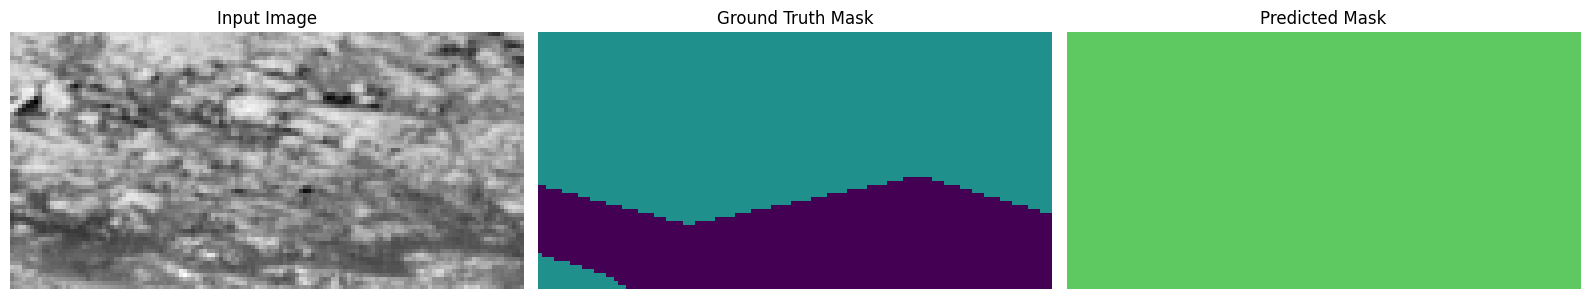

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 646ms/step - activation_30_mean_iou: 0.5731 - loss: 0.3520 - val_activation_30_mean_iou: 0.1043 - val_loss: 3.2728
Final validation Mean Intersection Over Union: 54.34%


In [26]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_activation_30_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
#del model

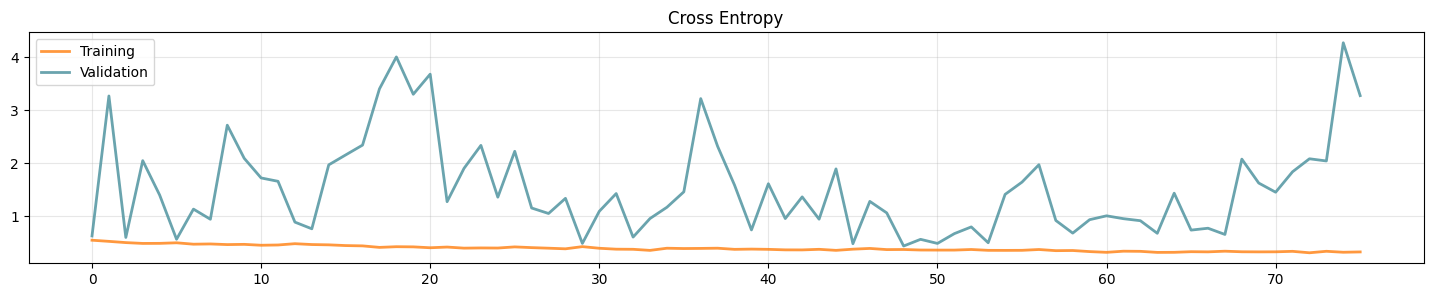

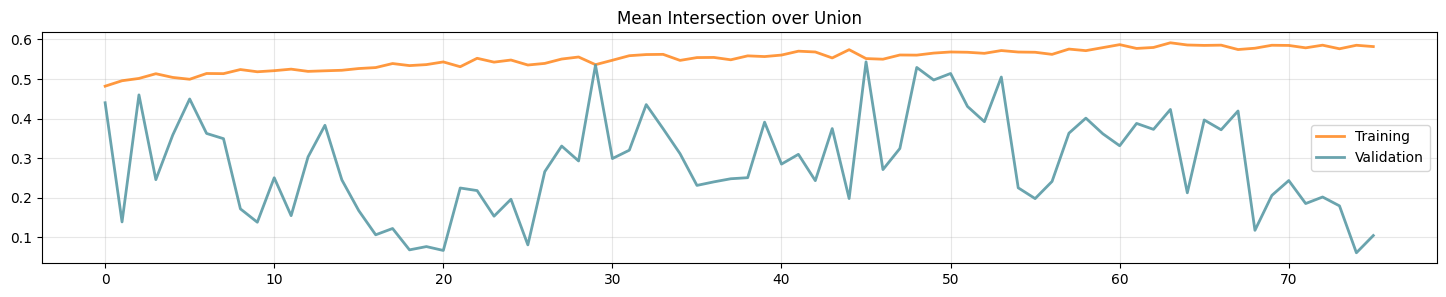

In [27]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
#plt.figure(figsize=(18, 3))
#plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
#plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
#plt.title('Accuracy')
#plt.legend()
#plt.grid(alpha=0.3)
#plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['activation_30_mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_activation_30_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [28]:
## If model_filename is not defined, load the most recent model from Google Drive
#if "model_filename" not in globals() or model_filename is None:
#    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#    if files:
#        model_filename = files[0]
#    else:
#        raise FileNotFoundError("No model files found in the current directory.")

In [29]:


#start_key = 586
#end_key = 10500  # Adjust this based on the expected range
#increment = 128
#
## Function to dynamically create custom_objects
#custom_objects = {
#    f'keras_tensor_{key}': repeat_elem
#    for key in range(start_key, end_key, increment)
#}
#
#
#model = tfk.models.load_model(model_filename, compile=False, safe_mode=False, custom_objects=custom_objects)
print(f"Model loaded from {model_filename}")

Model loaded from model_UNet_54.34.keras


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Predictions shape: (300, 64, 128)


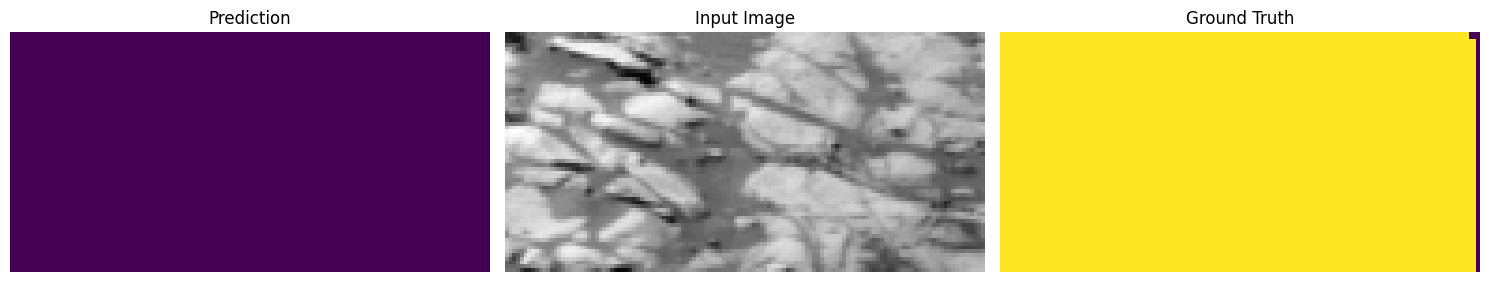

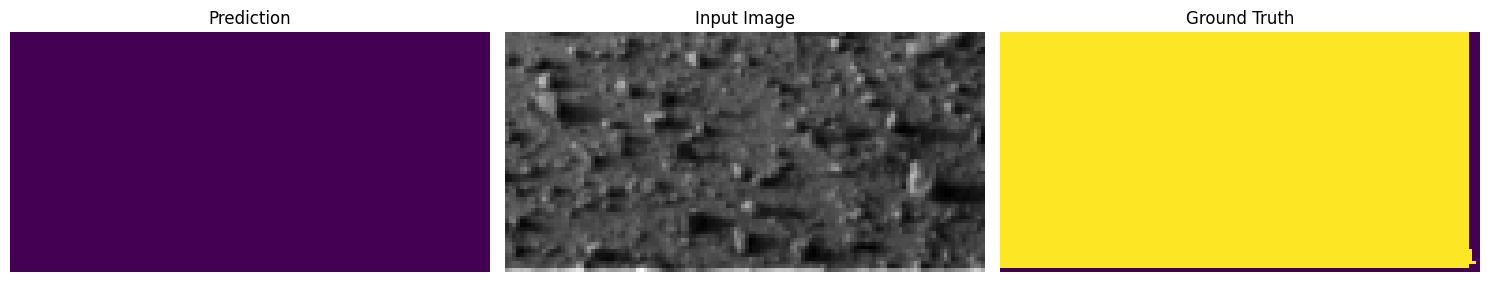

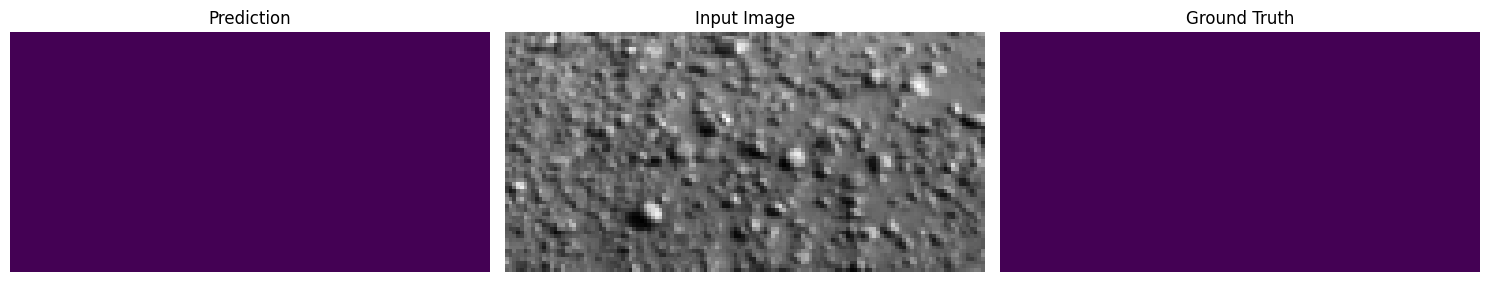

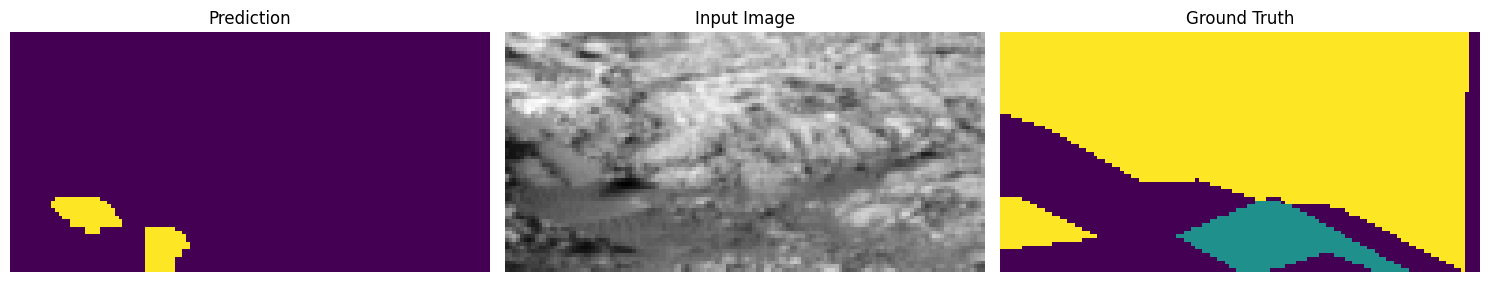

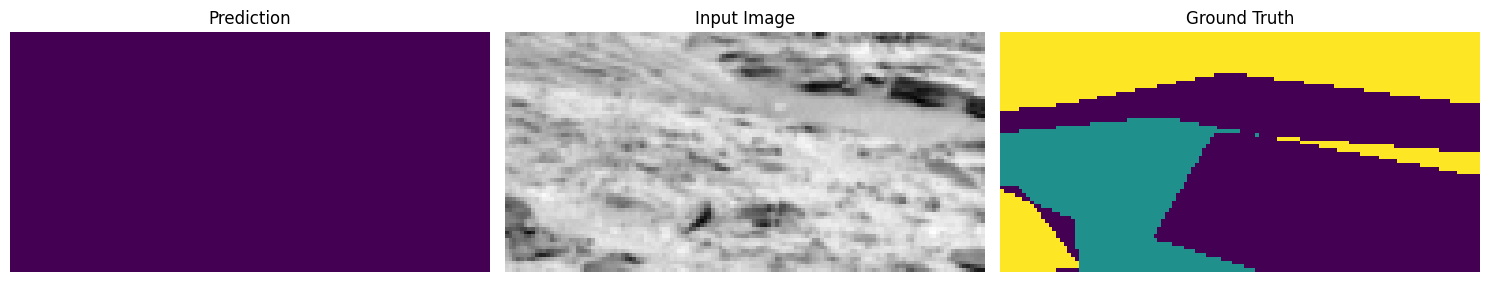

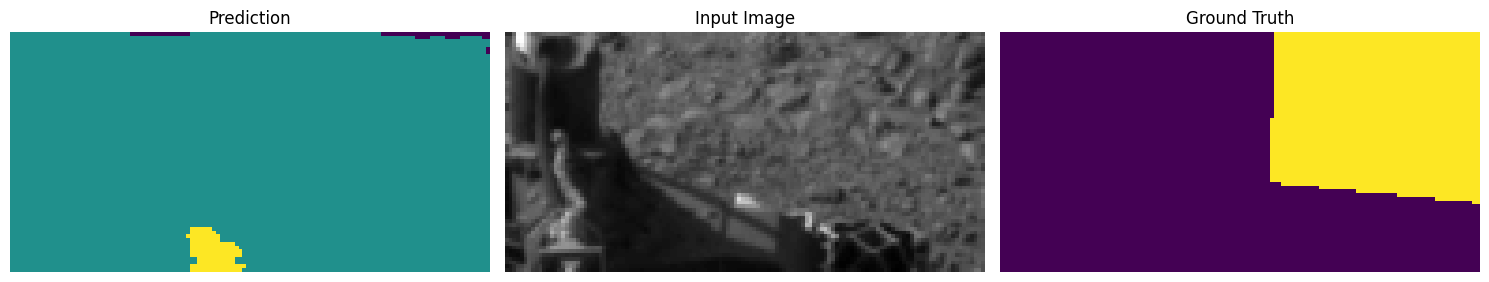

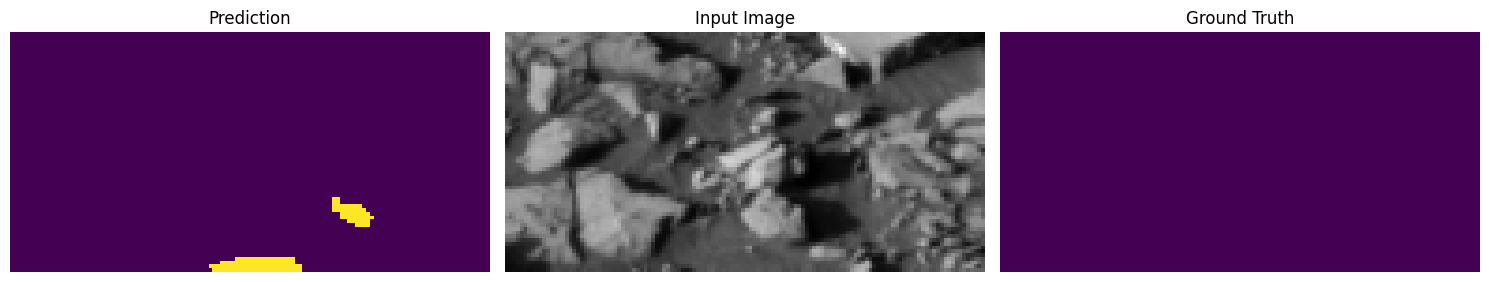

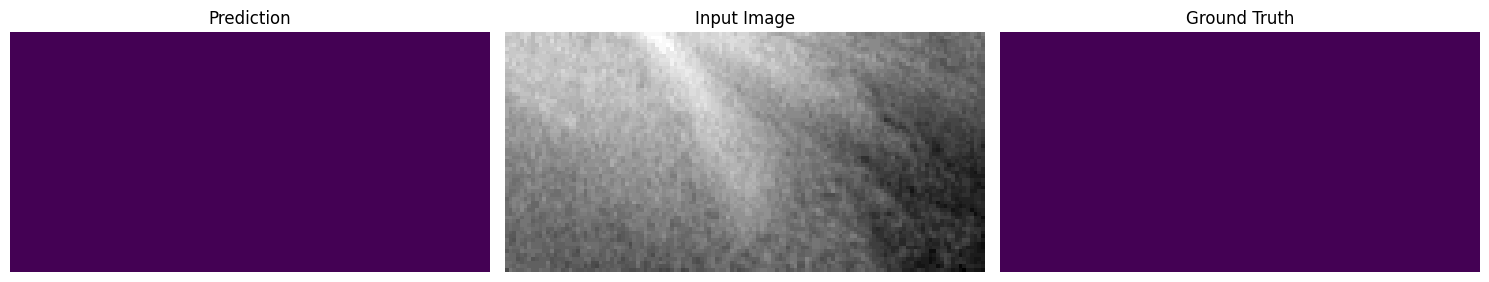

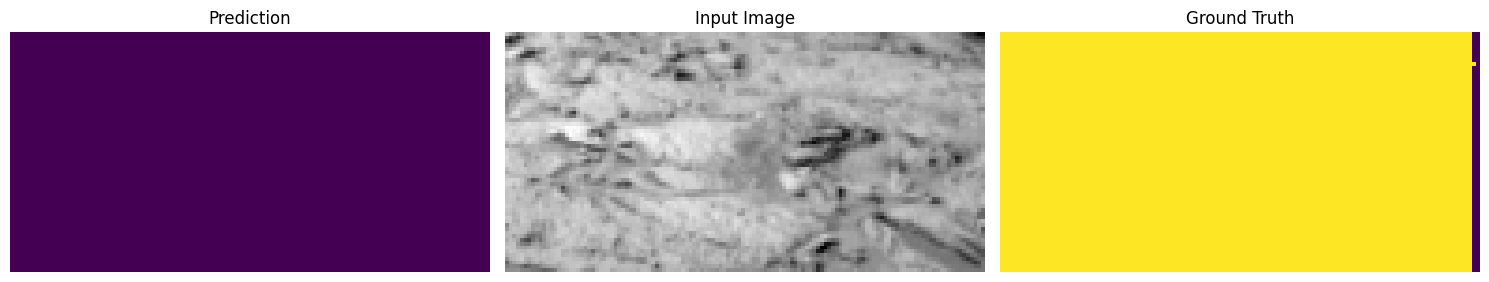

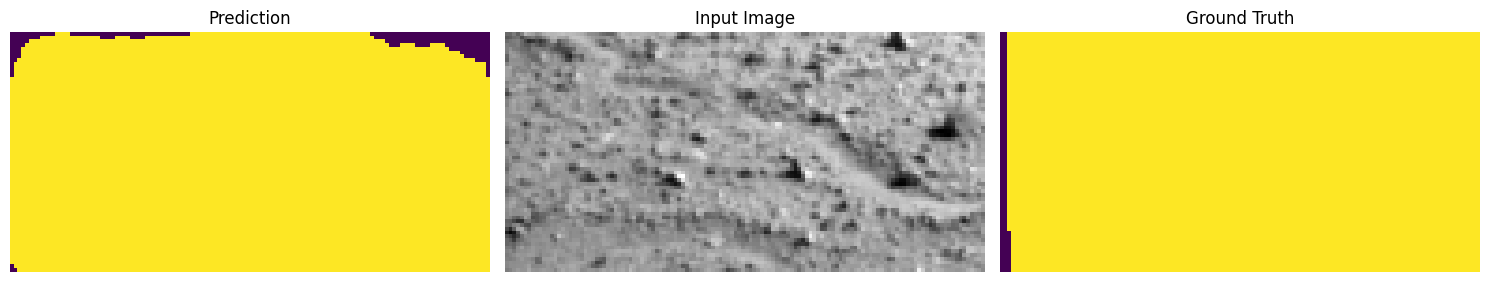

In [30]:
preds = model.predict(test_dataset)[0]
predicted_classes = np.argmax(preds, axis=-1)
preds[predicted_classes == 0] = -1
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(test_lbl[i])
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
preds = model.predict(X_test)[0]
predicted_classes = np.argmax(preds, axis=-1)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  print(preds.shape)
  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


314/314 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

In [ ]:
## disconnect time
from google.colab import runtime
runtime.unassign()

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```